In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib ipympl
import rowan
import numpy as np
from scipy.spatial.transform import Rotation as R
import math
import statistics
import pytransform3d.camera as pc
import pytransform3d.transformations as pt
import pytransform3d.rotations as pr


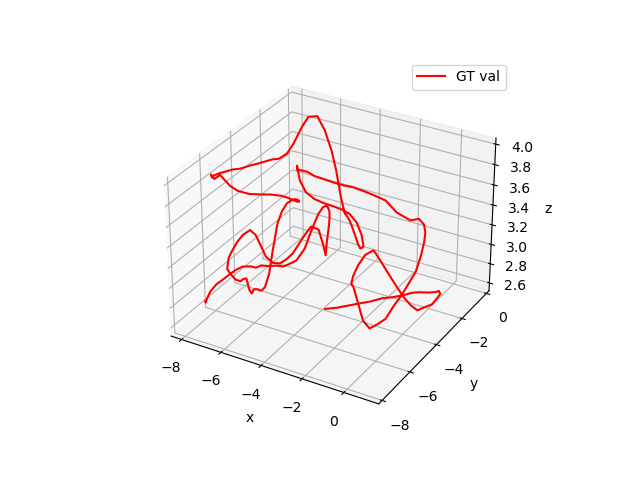

In [2]:
train_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/relative_pose/building_relative_v4/train/airsim_rec_0.txt', sep="\t")
# train_data = train_data.iloc[::2, :]
val_data = pd.read_csv(f'D:/Imperial/FYP/captured_data/airsim_drone_mode/relative_pose/building_relative_v4/val/airsim_rec_0.txt', sep="\t")

plt.figure()
ax = plt.axes(projection= '3d')
# ax.plot3D(train_data["POS_X"], train_data["POS_Y"], -train_data["POS_Z"], label = "GT train", color = 'blue')
# ax.scatter(train_data["POS_X"], train_data["POS_Y"], -train_data["POS_Z"], label = "GT train", color = 'blue')
ax.plot3D(val_data["POS_X"], val_data["POS_Y"], -val_data["POS_Z"], label = "GT val", color = 'red')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.legend()
plt.show()

Text(0.5, 0, 'z')

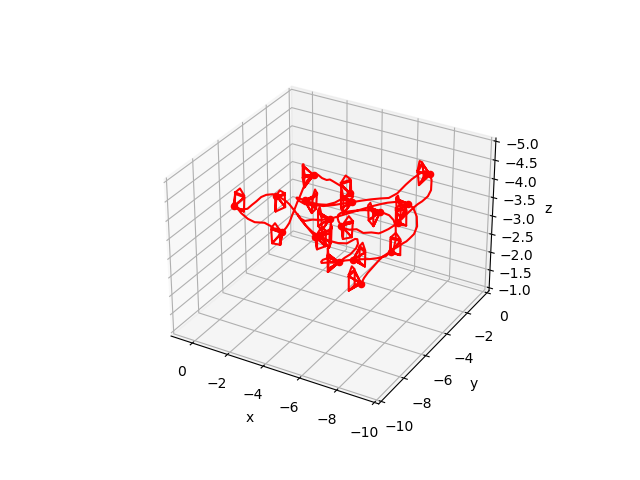

In [3]:
focal_length = 0.0036
sensor_size = (0.00367, 0.00274)
intrinsic_camera_matrix = np.array([
    [focal_length, 0, sensor_size[0] / 2],
    [0, focal_length, sensor_size[1] / 2],
    [0, 0, 1]
])
plt.figure()
ax = plt.axes(projection= '3d')
for index, row in val_data.iterrows():
    if index % 10 == 0:
        r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
        rotmat = r.as_matrix()
        # rotate to align to axis in pytransform3d
        rotmat2 = pr.matrix_from_euler_xyz(np.array([0, -np.pi/2, -np.pi/2]))
        cam2world = pt.transform_from(rotmat@rotmat2, np.hstack([ row["POS_X"], row["POS_Y"], row["POS_Z"]]))
        # print(np.hstack([ row["POS_X"], row["POS_Y"], row["POS_Z"]]))
        # print(cam2world)
        pc.plot_camera(ax, intrinsic_camera_matrix, cam2world,
                    sensor_size=sensor_size, virtual_image_distance=0.5, color = "red")
    # if index == 0: 
        # break

ax.plot3D(val_data["POS_X"], val_data["POS_Y"], val_data["POS_Z"], label = "GT val", color = 'red')
ax.set_xlim([1, -10])
ax.set_ylim([-10, 0])
ax.set_zlim([-1, -5])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

In [4]:
train_data["timestamp"] = pd.to_datetime(train_data["timestamp"], unit='ns')
train_data["seconds"] = (train_data["timestamp"] - train_data["timestamp"][0]).dt.total_seconds()
train_data["incremental_seconds"] = (train_data["seconds"] - train_data["seconds"].shift(1))
train_data["incremental_seconds"].fillna(0, inplace=True)
mean = statistics.mean(train_data["incremental_seconds"])
print(f"Average seconds between frames {mean}")

Average seconds between frames 0.25049772858715597


In [5]:
train_data["prev_Q_W"] = train_data["Q_W"].shift(1)
train_data["prev_Q_X"] = train_data["Q_X"].shift(1)
train_data["prev_Q_Y"] = train_data["Q_Y"].shift(1)
train_data["prev_Q_Z"] = train_data["Q_Z"].shift(1)
train_data["prev_POS_X"] = train_data["POS_X"].shift(1)
train_data["prev_POS_Y"] = train_data["POS_Y"].shift(1)
train_data["prev_POS_Z"] = train_data["POS_Z"].shift(1)

In [6]:
def euclidean_dist(prev_x, cur_x, prev_y, cur_y, prev_z, cur_z):
    return math.sqrt((prev_x - cur_x)**2 + (prev_y - cur_y)**2 + (prev_z - cur_z)**2)
train_data["distance_travelled"] = train_data.apply(lambda row: euclidean_dist(row["prev_POS_X"], row["POS_X"],row["prev_POS_Y"], row["POS_Y"], row["prev_POS_Z"], row["POS_Z"]), axis = 1)
mean = statistics.mean(train_data["distance_travelled"].iloc[1:])
print(f"Average dist between frames {mean}")

Average dist between frames 0.37861183385549957


## Acceleration

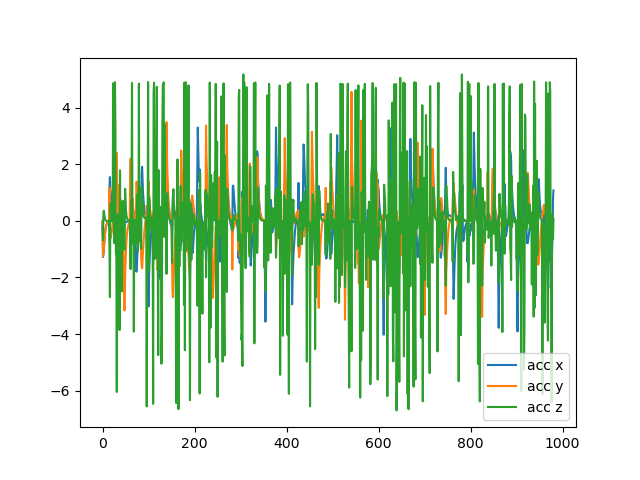

In [7]:
plt.figure()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

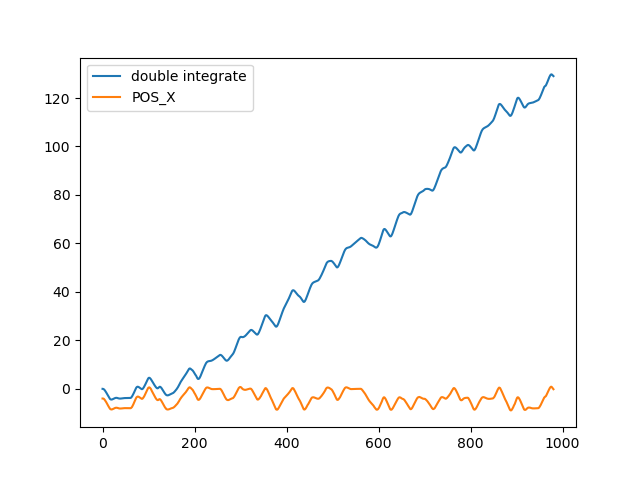

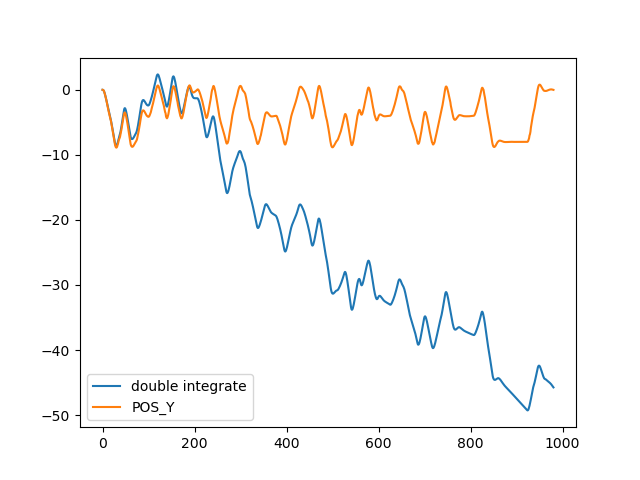

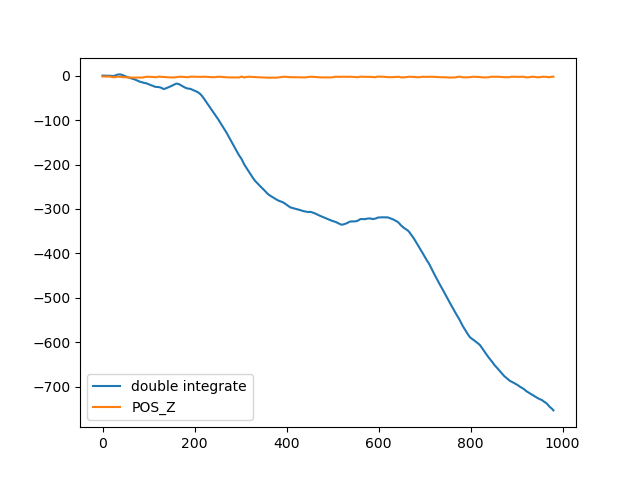

In [8]:
from scipy import integrate
t = train_data["seconds"]
velocity = integrate.cumtrapz(train_data["LIN_ACC_X"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.figure()
plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_X"], label = "POS_X")
plt.legend()

plt.figure()
velocity = integrate.cumtrapz(train_data["LIN_ACC_Y"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Y"], label = "POS_Y")
plt.legend()

plt.figure()
velocity = integrate.cumtrapz(train_data["LIN_ACC_Z"], t, initial=0)
displacement = integrate.cumtrapz(velocity, t, initial=0)

plt.plot(displacement, label = "double integrate")
plt.plot(train_data["POS_Z"], label = "POS_Z")
plt.legend()

In [9]:
train_data["prev_LIN_VEL_X"] = train_data["LIN_VEL_X"].shift(1)
train_data["prev_LIN_VEL_Y"] = train_data["LIN_VEL_Y"].shift(1)
train_data["prev_LIN_VEL_Z"] = train_data["LIN_VEL_Z"].shift(1)
train_data["prev_LIN_ACC_X"] = train_data["LIN_ACC_X"].shift(1)
train_data["prev_LIN_ACC_Y"] = train_data["LIN_ACC_Y"].shift(1)
train_data["prev_LIN_ACC_Z"] = train_data["LIN_ACC_Z"].shift(1)

In [10]:
def get_imu_pred_pose(prev_location, initial_velocity, cur_accel, timestep):
    return prev_location + initial_velocity * timestep + 1/2 * cur_accel * timestep**2
train_data["imu_pred_POS_X"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_X"], row["prev_LIN_VEL_X"], row["prev_LIN_ACC_X"], row["incremental_seconds"]), axis=1)
train_data["imu_pred_POS_Y"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_Y"], row["prev_LIN_VEL_Y"], row["prev_LIN_ACC_Y"], row["incremental_seconds"]), axis=1)
train_data["imu_pred_POS_Z"] = train_data.apply(lambda row : get_imu_pred_pose(row["prev_POS_Z"], row["prev_LIN_VEL_Z"], row["prev_LIN_ACC_Z"], row["incremental_seconds"]), axis=1)

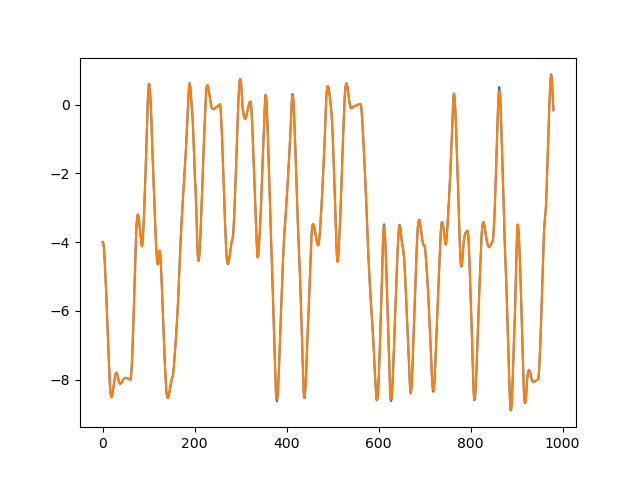

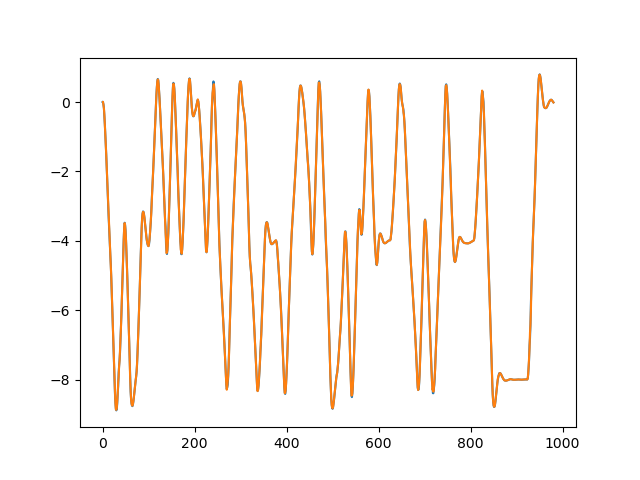

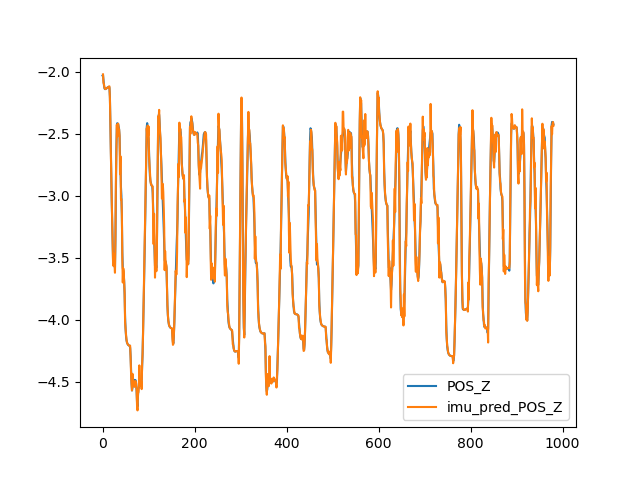

In [11]:
plt.figure()
train_data["POS_X"].plot()
train_data["imu_pred_POS_X"].plot()

plt.figure()
train_data["POS_Y"].plot()
train_data["imu_pred_POS_Y"].plot()

plt.figure()
train_data["POS_Z"].plot()
train_data["imu_pred_POS_Z"].plot()
plt.legend()

## Angular Velocity

In [39]:
train_data.fillna(0, inplace =True)
train_data.head()

,Vehicle_name,timestamp,POS_X,POS_Y,POS_Z,Q_W,Q_X,Q_Y,Q_Z,LIN_ACC_X,...,distance_travelled,prev_LIN_VEL_X,prev_LIN_VEL_Y,prev_LIN_VEL_Z,prev_LIN_ACC_X,prev_LIN_ACC_Y,prev_LIN_ACC_Z,imu_pred_POS_X,imu_pred_POS_Y,imu_pred_POS_Z
0,,2022-05-17 12:14:51.272629504,-3.997607,-0.000001,-2.029506,0.952417,-0.000602,-0.001810,0.304791,-0.004922,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,,2022-05-17 12:14:51.511114240,-4.001432,-0.011227,-2.023175,0.946807,-0.035667,0.072418,0.311512,-1.277277,...,0.013444,0.020672,-0.000182,0.062613,-0.004922,-0.002355,-0.195295,-3.992817,-0.000112,-2.020127
2,,2022-05-17 12:14:51.748099072,-4.053556,-0.066403,-2.064865,0.941969,-0.038074,0.080466,0.323683,-1.178195,...,0.086598,-0.172672,-0.190051,-0.190856,-1.277277,-1.251405,-0.682453,-4.078220,-0.091407,-2.087569
3,,2022-05-17 12:14:51.949086208,-4.166831,-0.181703,-2.104262,0.940597,-0.031556,0.068352,0.331074,-0.972193,...,0.166366,-0.470592,-0.481089,-0.196095,-1.178195,-1.147909,0.337834,-4.171936,-0.186281,-2.097454
4,,2022-05-17 12:14:52.195070464,-4.375514,-0.391040,-2.129868,0.942678,-0.022776,0.049183,0.329274,-0.721763,...,0.296692,-0.687126,-0.691747,-0.120973,-0.972193,-0.944604,0.357421,-4.365266,-0.380440,-2.123206


In [40]:
def integrate_angular_velocity(row):
	return rowan.calculus.integrate(np.hstack([row["prev_Q_W"], row["prev_Q_X"], row["prev_Q_Y"], row["prev_Q_Z"]]), 
							 np.hstack([row["ANG_VEL_X"],row["ANG_VEL_Y"], row["ANG_VEL_Z"]]), row["incremental_seconds"])

train_data["pred_Q_W"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[0], axis=1)
train_data["pred_Q_X"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[1], axis=1)
train_data["pred_Q_Y"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[2], axis=1)
train_data["pred_Q_Z"] = train_data.iloc[1:,:].apply(lambda row: integrate_angular_velocity(row)[3], axis=1)

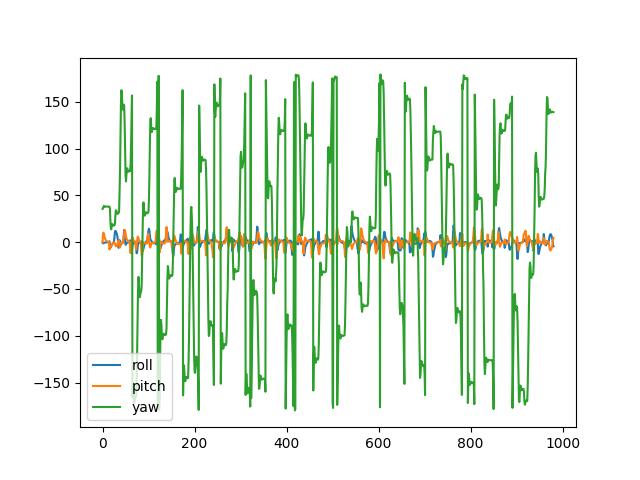

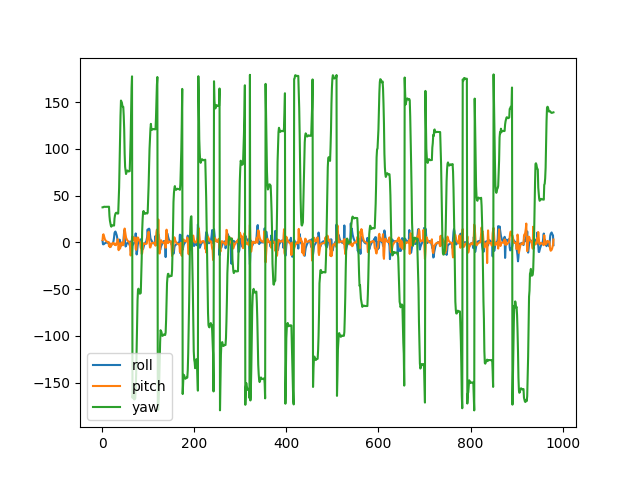

In [41]:
def convert_quat_to_euler(row, pred=False):
	if pred:
		r = R.from_quat(np.hstack([row["pred_Q_X"], row["pred_Q_Y"], row["pred_Q_Z"], row["pred_Q_W"]]))
	else:
		r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
	return r.as_euler('xyz', degrees = True) #extrinsic rotation (Fixed frame)

train_data["roll"] = train_data.apply(lambda row: convert_quat_to_euler(row)[0], axis=1)
train_data["pitch"] =train_data.apply(lambda row: convert_quat_to_euler(row)[1], axis=1) 
train_data["yaw"] = train_data.apply(lambda row: convert_quat_to_euler(row)[2], axis=1)
train_data["pred_roll"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[0], axis=1)
train_data["pred_pitch"] =train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[1], axis=1) 
train_data["pred_yaw"] = train_data.iloc[1:,:].apply(lambda row: convert_quat_to_euler(row, True)[2], axis=1)

plt.figure()
train_data["roll"].plot()
train_data["pitch"].plot()
train_data["yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

plt.figure()
train_data["pred_roll"].plot()
train_data["pred_pitch"].plot()
train_data["pred_yaw"].plot()
plt.legend(["roll", "pitch", "yaw"])

## Handling IMU

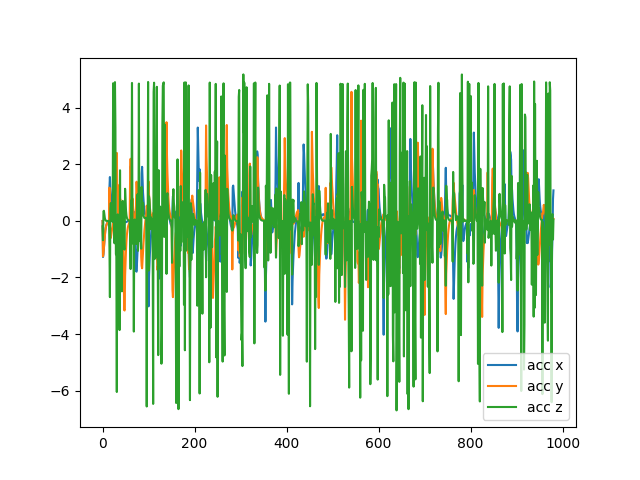

In [42]:
plt.figure()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
train_data["LIN_ACC_Z"].plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

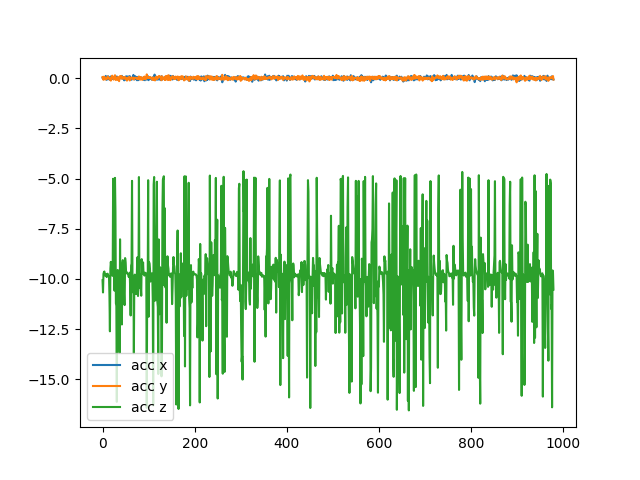

In [43]:
plt.figure()
train_data.iloc[:-1,:]["S_LIN_ACC_X"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Y"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Z"].astype(float).plot()
plt.legend(["acc x", "acc y", "acc z"])
plt.show()

In [44]:
def convert_body_to_world(row):
	body_acc = np.hstack([row["S_LIN_ACC_X"], row["S_LIN_ACC_Y"], row["S_LIN_ACC_Z"]]).astype(float)
	r = R.from_quat(np.hstack([row["Q_X"], row["Q_Y"], row["Q_Z"], row["Q_W"]]))
	world_acc = r.apply(body_acc)
	return world_acc - np.array([0, 0, -9.81])
train_data["S_LIN_ACC_X_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[0], axis = 1)
train_data["S_LIN_ACC_Y_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[1], axis = 1)
train_data["S_LIN_ACC_Z_world"] = train_data.iloc[:-1,:].apply(lambda row : convert_body_to_world(row)[2], axis = 1)

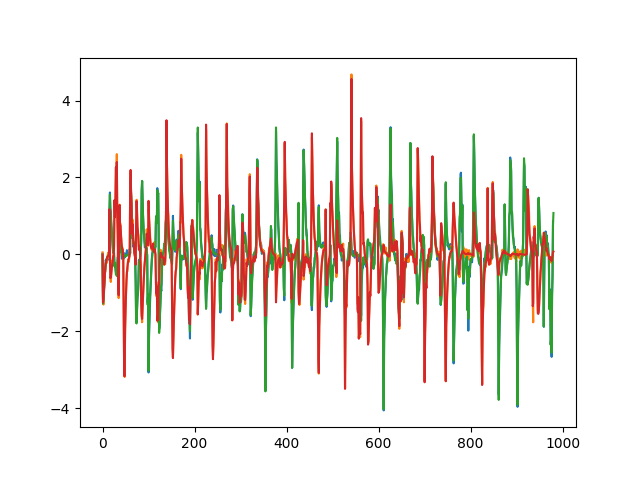

In [47]:
plt.figure()
train_data.iloc[:-1,:]["S_LIN_ACC_X_world"].astype(float).plot()
train_data.iloc[:-1,:]["S_LIN_ACC_Y_world"].astype(float).plot()
# train_data.iloc[:-1,:]["S_LIN_ACC_Z_world"].astype(float).plot()
train_data["LIN_ACC_X"].plot()
train_data["LIN_ACC_Y"].plot()
# train_data["LIN_ACC_Z"].plot()
# plt.legend(["acc x_S", "acc y_S", "acc z_S", "acc x", "acc y", "acc z"])
plt.show()